# Resume Parsing

So basically, we want to create a entity ruler to parse real resume and get the "skills".



Installing PyPDF2

In [13]:
!pip install PyPDF2

In [14]:
!pip install -U pip setuptools wheel


  Using cached pip-23.0-py3-none-any.whl (2.1 MB)
  Using cached setuptools-67.2.0-py3-none-any.whl (1.1 MB)
  Using cached wheel-0.38.4-py3-none-any.whl (36 kB)


ERROR: To modify pip, please run the following command:
C:\Users\Paramik\anaconda3\python.exe -m pip install -U pip setuptools wheel


In [15]:
!pip install -U spacy

In [16]:
!python -m spacy download en_core_web_md

     ---------------------------------------- 42.8/42.8 MB 9.0 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


## 1. Load data

In [4]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("./resume.csv")

In [4]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]  #optional if your computer is fast, no need
df_resume.shape

(1000, 4)

## 2. Load skill data



In [5]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "./skills.jsonl"

In [6]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [7]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

## 3. Let's try to extract skills from this resume.csv

In [8]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1673,52252936,OFFICE MANAGER - 40+ HOURS PER WEEK ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL
350,66906212,TEACHER Summary Thank y...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER
2247,10329506,REGISTERED CLIENT SERVICE ASSOCIATE ...,"<div class=""fontsize fontface vmargins hmargin...",BANKING
74,28808263,HR PAYROLL/ ACCOUNTING REPRESENTATIVE...,"<div class=""fontsize fontface vmargins hmargin...",HR
1637,91533580,STORE MANAGER Summary En...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL


In [9]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [10]:
#let's try Chaky, if you feel too dangerous
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

"           CONSULTANT       Professional Summary         \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nAstute\nand innovative attorney with strong ability to develop and implement effective litigation case\nstrategies and write persuasive motions. Proven ability to resolve complex cases in\nclients' favor.\xa0 Meticulous,\nconscientio"

In [11]:
preprocessing(random_resume[:300])

"consultant professional summary astute innovative attorney strong ability develop implement effective litigation case strategy write persuasive motion prove ability resolve complex case client ' favor meticulous conscientio"

In [12]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [13]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1673,52252936,OFFICE MANAGER - 40+ HOURS PER WEEK ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,office manager 40 hour per week professional s...
350,66906212,TEACHER Summary Thank y...,"<div class=""fontsize fontface vmargins hmargin...",TEACHER,teacher summary thank take time read i present...
2247,10329506,REGISTERED CLIENT SERVICE ASSOCIATE ...,"<div class=""fontsize fontface vmargins hmargin...",BANKING,registered client service associate summary to...
74,28808263,HR PAYROLL/ ACCOUNTING REPRESENTATIVE...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr payroll/ accounting representative summary ...
1637,91533580,STORE MANAGER Summary En...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,store manager summary energetic versatile prof...


## 4. Let's really extract skills!!

In [14]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

## 5. Lets extract Education

In [15]:
def get_education(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    education = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "EDUCATION":
            education.append(ent.text)
    
    return education

def unique_education(x):
    return list(set(x))

In [16]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
1673,52252936,OFFICE MANAGER - 40+ HOURS PER WEEK ...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,office manager 40 hour per week professional s...


In [17]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [18]:
df_resume['Education'] = df_resume.Clean_resume.apply(get_education)
df_resume['Education'] = df_resume.Education.apply(unique_education)

In [19]:
df_resume.Skills.iloc[0]

['marketing', 'database', 'software', 'schedule', 'support']

In [20]:
df_resume.Education.iloc[0]

[]

## 5. Visualization

Which skills is most important in information management?

In [32]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [33]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(51, 6)

In [5]:
all_skill = np.concatenate(df_resume_it.Skills.values)

NameError: name 'df_resume_it' is not defined

In [2]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

NameError: name 'all_skill' is not defined

In [36]:
counting

OrderedDict([('support', 48),
             ('software', 42),
             ('business', 37),
             ('security', 35),
             ('design', 34),
             ('server', 33),
             ('windows', 31),
             ('database', 27),
             ('documentation', 27),
             ('project management', 26)])

NameError: name 'counting' is not defined

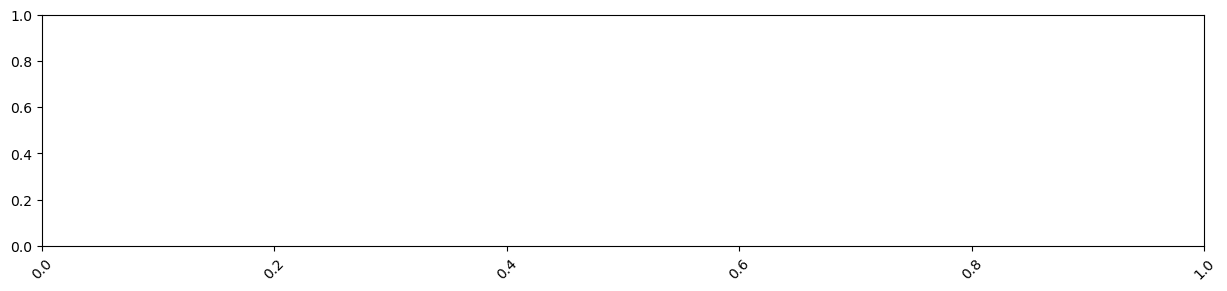

In [1]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

In [ ]:
all_education = np.concatenate(df_resume_it.Education.values)

In [ ]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [ ]:
counting

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [ ]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [ ]:
doc = nlp(text)

In [ ]:
nlp.pipe_names

In [2]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)", "EDCUATION": "linear-gradient(90deg, #221f32, #110f19)"}
#colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

NameError: name 'displacy' is not defined

## 7. Let's load the PDF - add some realism

In [ ]:
from PyPDF2 import PdfReader
#pip install PyPDF2

reader = PdfReader("./word2vec.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [ ]:
text = preprocessing(text)

In [ ]:
doc = nlp(text)

In [ ]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)", "EDCUATION":"linear-gradient(90deg, #221f32, #110f19)" }

#colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [ ]:
#last thing i go to assignment
#collect all the skill and put it into a list

skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))

In [ ]:
def unique_skills_and_education(doc):
    skills    = []
    education = []

    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
        elif ent.label_ == 'EDUCATION':
            education.append(ent.text)
            
    return set(skills), set(education)

print(unique_skills_and_education(doc))